# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [19]:
import os
import sys
import random
import math
import re
from skimage import data, io
from matplotlib import pyplot as plt 
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import skimage

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [20]:
import imgaug
from imgaug import augmenters

class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    #IMAGE_MIN_DIM = 128
    #IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    #TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [21]:

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [22]:
class BalloonDataset(utils.Dataset):

    def load_balloon(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("balloon", 1, "balloon")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
            #print(polygons)
        
            
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            print(a['filename'])               
            self.add_image(
                "balloon",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "balloon":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



dataset_train = BalloonDataset()
dataset_train.load_balloon('/home/harsh/Mask_RCNN/datasets/balloon', "train")


34020010494_e5cb88e1c4_k.jpg
25899693952_7c8b8b9edc_k.jpg
24362039530_b151b41a52_k.jpg
18849792632_aad23ad513_k.jpg
17178818589_16e58fc1e5_k.jpg
17156759330_5af4f5a5b8_k.jpg
16435593892_2aa8118f4a_k.jpg
15717689633_5f7f78c28e_k.jpg
15331928994_d5b82eb368_k.jpg
15290896925_884ab33fd3_k.jpg
14666848163_8be8e37562_k.jpg
14321263043_b76ef054d3_k.jpg
12288446656_2c6a90e6f5_k.jpg
12288355124_5e340d3de3_k.jpg
12288043903_fe1ea17a4e_k.jpg
12037308314_e16fb3a0f7_k.jpg
10464445726_6f1e3bbe6a_k.jpg
9330497995_4cf0438cb6_k.jpg
9210739293_2b0e0d991e_k.jpg
8758393087_76fcd56bd3_k.jpg
8436015314_3a678c1005_k.jpg
7488015492_0583857ca0_k.jpg
7308740338_591f27b631_k.jpg
7178882742_f090f3ce56_k.jpg
6483318883_21facf57cd_b.jpg
5674044810_2d9e2243ff_b.jpg
5560377994_cb597a4af5_b.jpg
5253122239_38b1e7f61c_b.jpg
5178670692_63a4365c9c_b.jpg
5013250607_26359229b6_b.jpg
4955354786_337a598e4a_b.jpg
4887227769_acd2e6127d_b.jpg
4864857993_edb62f16ef_b.jpg
4552737035_3a0a4105fb_b.jpg
4543126482_92254ef046_b.jpg
405

In [29]:
# Training dataset
dataset_train = BalloonDataset()
dataset_train.load_balloon('/home/harsh/Mask_RCNN/datasets/balloon', "train")
dataset_train.prepare()

# Validation dataset
dataset_val = BalloonDataset()
dataset_val.load_balloon('/home/harsh/Mask_RCNN/datasets/balloon', "train")
dataset_val.prepare()

34020010494_e5cb88e1c4_k.jpg
25899693952_7c8b8b9edc_k.jpg
24362039530_b151b41a52_k.jpg
18849792632_aad23ad513_k.jpg
17178818589_16e58fc1e5_k.jpg
17156759330_5af4f5a5b8_k.jpg
16435593892_2aa8118f4a_k.jpg
15717689633_5f7f78c28e_k.jpg
15331928994_d5b82eb368_k.jpg
15290896925_884ab33fd3_k.jpg
14666848163_8be8e37562_k.jpg
14321263043_b76ef054d3_k.jpg
12288446656_2c6a90e6f5_k.jpg
12288355124_5e340d3de3_k.jpg
12288043903_fe1ea17a4e_k.jpg
12037308314_e16fb3a0f7_k.jpg
10464445726_6f1e3bbe6a_k.jpg
9330497995_4cf0438cb6_k.jpg
9210739293_2b0e0d991e_k.jpg
8758393087_76fcd56bd3_k.jpg
8436015314_3a678c1005_k.jpg
7488015492_0583857ca0_k.jpg
7308740338_591f27b631_k.jpg
7178882742_f090f3ce56_k.jpg
6483318883_21facf57cd_b.jpg
5674044810_2d9e2243ff_b.jpg
5560377994_cb597a4af5_b.jpg
5253122239_38b1e7f61c_b.jpg
5178670692_63a4365c9c_b.jpg
5013250607_26359229b6_b.jpg
4955354786_337a598e4a_b.jpg
4887227769_acd2e6127d_b.jpg
4864857993_edb62f16ef_b.jpg
4552737035_3a0a4105fb_b.jpg
4543126482_92254ef046_b.jpg
405

[15 35 30  4]


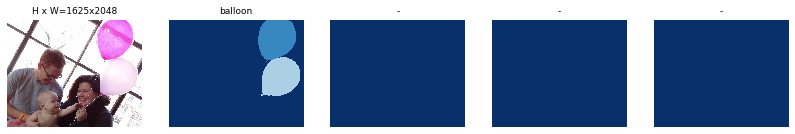

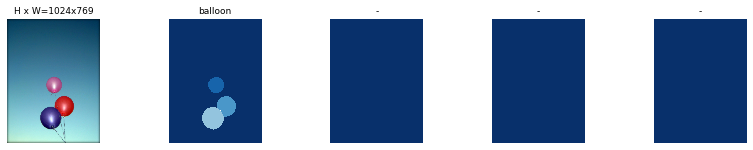

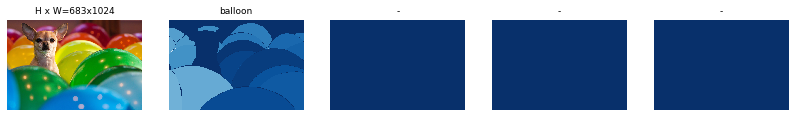

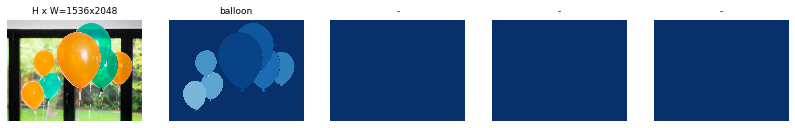

In [30]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
print(image_ids)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)    
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [40]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa


ia.seed(1)

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(32)],
    dtype=np.uint8
)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

## Create Model

In [41]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [42]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [43]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads', augmentation = seq)


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190817T1849/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask

/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/keras/engine/training

Epoch 1/1


Process ForkPoolWorker-63:
Process ForkPoolWorker-62:
Process ForkPoolWorker-61:
Process ForkPoolWorker-58:
Process ForkPoolWorker-65:
Process ForkPoolWorker-60:
Process ForkPoolWorker-70:
Process ForkPoolWorker-68:
Process ForkPoolWorker-64:
Process ForkPoolWorker-67:
Process ForkPoolWorker-57:
Process ForkPoolWorker-72:
Process ForkPoolWorker-69:
Process ForkPoolWorker-66:
Process ForkPoolWorker-59:
Process ForkPoolWorker-71:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/harsh/anaconda3/envs/maskrcnn/lib/py

  File "/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-22-2a53d5d1ae66>", line 85, in load_mask
    rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
  File "/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/model.py", line 1212, in load_image_gt
    mask, cl

  File "/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/utils.py", line 448, in resize_image
    preserve_range=True)
  File "/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/utils.py", line 903, in resize
    anti_aliasing_sigma=anti_aliasing_sigma)
  File "/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/utils.py", line 448, in resize_image
    preserve_range=True)
  File "/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/utils.py", line 903, in resize
    anti_aliasing_sigma=anti_aliasing_sigma)
  File "/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/utils.py", line 903, in resize
    anti_aliasing_sigma=anti_aliasing_sigma)
  File "/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/skimage/transform/_warps.py", line 179, in resize
    image = conv

Epoch 1/1


  File "/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/skimage/_shared/utils.py", line 239, in convert_to_float
    """
KeyboardInterrupt


KeyboardInterrupt: 

In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190814T2309/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_bran

/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/keras/engine/training

Epoch 2/2
100/100 [==============================] - 1113s 11s/step - loss: 0.8326 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4058 - mrcnn_class_loss: 0.1252 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.1488 - val_loss: 0.8168 - val_rpn_class_loss: 0.0180 - val_rpn_bbox_loss: 0.4677 - val_mrcnn_class_loss: 0.1084 - val_mrcnn_bbox_loss: 0.1197 - val_mrcnn_mask_loss: 0.1030


In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Detection

In [12]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

W0814 23:47:26.397996 139866865075968 deprecation_wrapper.py:119] From /home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/model.py:720: The name tf.sets.set_intersection is deprecated. Please use tf.sets.intersection instead.

W0814 23:47:26.454785 139866865075968 deprecation.py:323] From /home/harsh/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/model.py:772: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Loading weights from  /home/harsh/Mask_RCNN/logs/shapes20190814T2309/mask_rcnn_shapes_0002.h5
Re-starting from epoch 2


original_image           shape: (128, 128, 3)         min:   23.00000  max:  221.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (3,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (3, 4)                min:    3.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 3)         min:    0.00000  max:    1.00000  bool


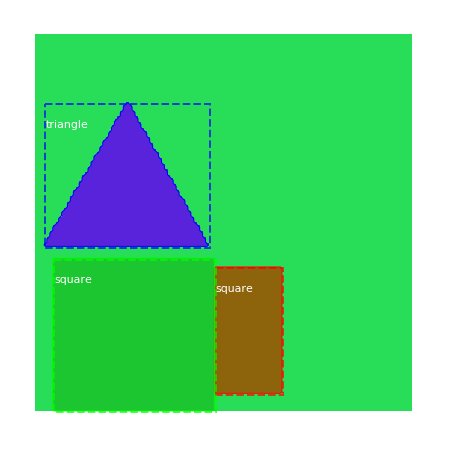

In [13]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:   23.00000  max:  221.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -96.70000  max:  104.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


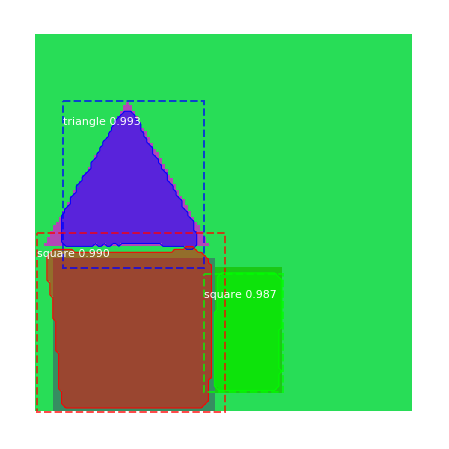

In [14]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [15]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.9166666686534881
